In [1]:
import sympy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
x = sp.symbols('x')
f = 1 / (x**2 + 1)
a, b = -1, 1
new_node = 0.15
order = 7

# Let's plot it!

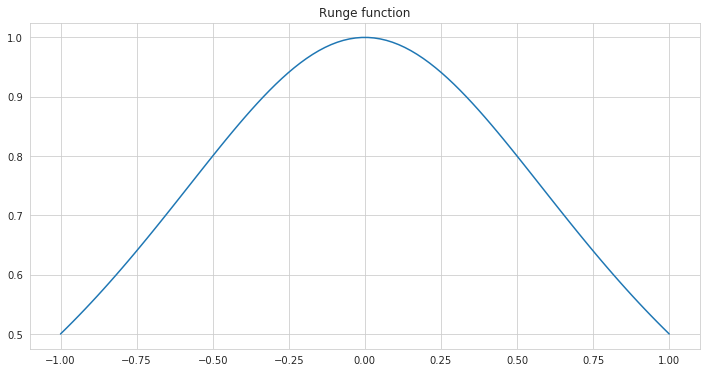

In [3]:
x_plot = np.linspace(a, b, 100, endpoint=True)
y_plot = sp.lambdify(x, f, 'numpy')(x_plot)
dy_plot = sp.lambdify(x, sp.diff(f), 'numpy')(x_plot)

sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))
sns.lineplot(x_plot, y_plot).set_title('Runge function');

# Interpolation using Chebyshev's polynomial

In [4]:
# Compute Chebyshev nodes
nodes = [np.cos(np.pi * (2 * k + 1) / (2 * order)) for k in range(order)]
values = [f.evalf(subs={x: n}) for n in nodes]

> Note: The code below is mostly taken from task-1

In [5]:
# Helper function to compute divided differences
def div_diffs(nodes, values, max_order):
    if len(nodes) != len(values):
        raise ValueError("nodes and values lists must have the same length")
    diffs = [values]
    for order in range(max_order):
        current_diffs = []
        for i in range(1, len(nodes) - order):
            current_diffs.append((diffs[-1][i] - diffs[-1][i-1]) / (nodes[i + order] - nodes[i-1]))
        diffs.append(current_diffs)
    return diffs

In [6]:
# Helper function to nicely print divided differences
def print_diffs(diffs):
    rows = 2 * len(diffs[0]) - 1
    for r in range(rows):
        row = '\t' if r % 2 == 1 else ''
        for i in range(r % 2, min(rows - r, min(r + 1, len(diffs))), 2):
            row += f'{float(diffs[i][(r - i) // 2]):.4f}\t\t'
        print(row[:-2])

In [7]:
dds = div_diffs(nodes, values, order - 1)
print_diffs(dds)

0.5127
	-0.5590
0.6206		0.1404
	-0.6350		0.4981
0.8416		-0.3451		0.0637
	-0.3651		0.4084		-0.2611
1.0000		-0.8416		0.5223		-0.2678
	0.3651		-0.4084		0.2611
0.8416		-0.3451		0.0637
	0.6350		-0.4981
0.6206		0.1404
	0.5590
0.5127


In [8]:
for pos in range(len(nodes)):
    if nodes[pos] > new_node:
        break
# pos is where we'd put the new node among the others

In [9]:
# Find position of the closest by value nodes
i, j = pos - 1, pos
pos_around_new = []
while (j - i) <= order:
    if i < 0 and j >= len(nodes):
        break
    if j >= len(nodes) or new_node - nodes[i] <= nodes[j] - new_node:
        pos_around_new.append(i)
        i -= 1
    else:
        pos_around_new.append(j)
        j += 1

In [10]:
nodes_around_new = [nodes[i] for i in pos_around_new]

In [11]:
polynom = 0
mult = 1
for o in range(order):
    m = min(pos_around_new[:o+1])
    polynom += dds[o][m] * mult
    mult *= x - nodes[pos_around_new[o]]
chebyshev_estimated_value = polynom.evalf(subs={x: new_node})

Estimated value: 0.978528748953975
True value: 0.977995110024450


# Interpolation using equally spaced nodes

> It only supports forward interpolation, thus may fail with some orders. I'll fix it soon :)

In [12]:
def finite_differences(nodes, values, max_order):
    if len(nodes) != len(values):
        raise ValueError("nodes and values lists must have the same length")
    diffs = [values]
    for order in range(max_order):
        current_diffs = []
        for i in range(1, len(nodes) - order):
            current_diffs.append(diffs[-1][i] - diffs[-1][i-1])
        diffs.append(current_diffs)
    return diffs

In [13]:
nodes = np.linspace(a, b, order)
step = (b - a) / (order - 1)
values = sp.lambdify(x, f, 'numpy')(nodes)

for n, v in zip(nodes, values):
    print(f'f({n:.3g}) = {v:.5g}')

f(-1) = 0.5
f(-0.667) = 0.69231
f(-0.333) = 0.9
f(0) = 1
f(0.333) = 0.9
f(0.667) = 0.69231
f(1) = 0.5


In [14]:
fds = finite_differences(nodes, values, order - 1)

In [15]:
print_diffs(fds)

0.5000
	0.1923
0.6923		0.0154
	0.2077		-0.1231
0.9000		-0.1077		0.0308
	0.1000		-0.0923		0.1538
1.0000		-0.2000		0.1846		-0.3077
	-0.1000		0.0923		-0.1538
0.9000		-0.1077		0.0308
	-0.2077		0.1231
0.6923		0.0154
	-0.1923
0.5000


In [16]:
nearest_pos, nearest_node = None, None
for i, n in enumerate(nodes):
    if n < new_node and new_node <= n + step/2:
        nearest_pos, nearest_node = i, n

In [17]:
t = (x - nearest_node) / step

In [18]:
ns = [1]
mult = -1
for i in range(1, order):
    ns.append(ns[-1] * (t - mult * (i // 2)) / i)
    mult *= -1

In [19]:
ns, len(ns)

([1,
  3.0*x,
  1.5*x*(3.0*x - 1),
  0.5*x*(3.0*x - 1)*(3.0*x + 1),
  0.125*x*(3.0*x - 2)*(3.0*x - 1)*(3.0*x + 1),
  0.025*x*(3.0*x - 2)*(3.0*x - 1)*(3.0*x + 1)*(3.0*x + 2),
  0.00416666666666667*x*(3.0*x - 3)*(3.0*x - 2)*(3.0*x - 1)*(3.0*x + 1)*(3.0*x + 2)],
 7)

In [20]:
polynom = 0
for i in range(order):
    polynom += ns[i] * fds[i][nearest_pos - i // 2]
esn_estimated_value = polynom.evalf(subs={x: new_node})

In [27]:
true_value = f.evalf(subs={x: new_node})

In [28]:
pd.DataFrame([
        [chebyshev_estimated_value, true_value - chebyshev_estimated_value],
        [esn_estimated_value, true_value - esn_estimated_value],
        [true_value, 0]
    ], index=['Estimation using Chebyshev nodes', 'Estimation using equally spaced nodes', 'True value'],
    columns=[f'{order} nodes', 'Error']
)

,7 nodes,Error
Estimation using Chebyshev nodes,0.978528748953975,-0.000533638929525071
Estimation using equally spaced nodes,0.978245658112981,-0.000250548088530866
True value,0.977995110024450,0
